In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

df = pd.read_csv('glass.csv')

<AxesSubplot:>

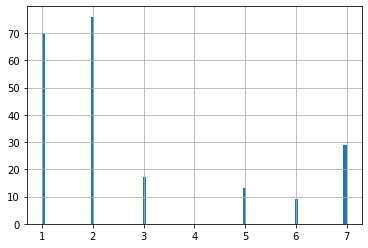

In [2]:
df.Type.hist(bins=100)

In [3]:
df.loc[df.Type==4]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type


Данных очень мало.

Нет записей одного класса (4).  
Двух классов почти в 10 раз больше, чем остальных.  

Построим RandomForestClassifier и посчитаем его accuracy_score

In [4]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
def get_rf_score(data,max_depth = 2):
    X = data[['RI',	'Na',	'Mg',	'Al',	'Si',	'K',	'Ca',	'Ba',	'Fe']]
    # [c for c in df.columns if c != 'Type']
    y = np.ravel(data[['Type']])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 ) 
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    # y_pred = clf.predict(X_test)
    print(clf.score(X_test, y_test)) # это и есть accuracy score, сравнивал


In [5]:
get_rf_score(df, max_depth=10)

0.6744186046511628


<AxesSubplot:xlabel='Type', ylabel='RI'>

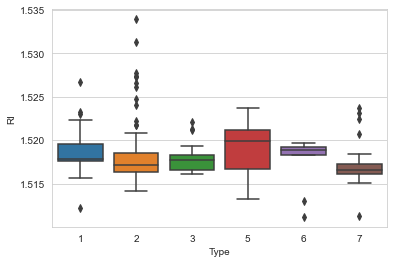

In [6]:
sns.set_style("whitegrid")
sns.boxplot(x = 'Type', y = 'RI', data = df)

<AxesSubplot:xlabel='Type', ylabel='Na'>

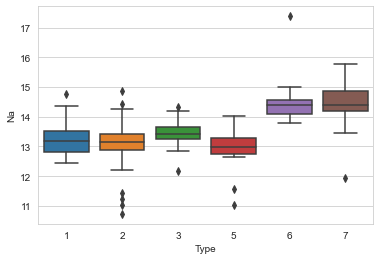

In [7]:
sns.boxplot(x = 'Type', y = 'Na', data = df)

C:\Users\Sergei\anaconda3\envs\uoit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


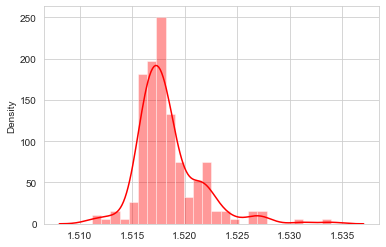

In [8]:
ax = sns.distplot(df[['RI']],color='red')


C:\Users\Sergei\anaconda3\envs\uoit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


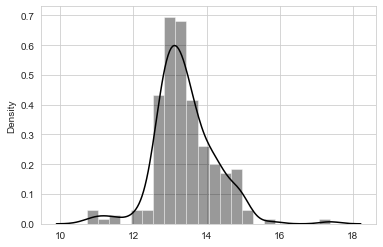

In [9]:
ax = sns.distplot(df[['Na']],color='black')


Распределения близки к нормальным. Только правая половина растянута.

Можно считать выбросами все точки вне 3 сигма.

In [10]:
from numpy import mean
from numpy import std
def outliers_sep(data, n_sigma = 3):
    # calculate summary statistics
    data_mean, data_std = mean(data), std(data)
    # identify outliers
    cut_off = data_std * n_sigma
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # identify outliers
    c_name = data.columns[0]
    # print(lower)
    # outliers = [x for x in data[c_name] if x < float(lower) or x > float(upper)]
    outliers = data.loc[(data[c_name] < float(lower)) | (data[c_name] > float(upper))]
    # remove outliers
    outliers_removed = data.loc[(data[c_name] > float(lower)) & (data[c_name] < float(upper))]
    # outliers_removed = outliers
    return outliers_removed, outliers


C:\Users\Sergei\anaconda3\envs\uoit\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


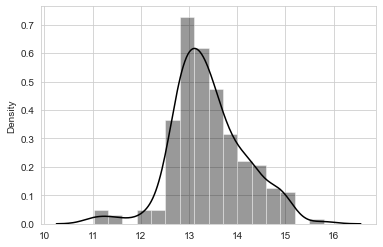

In [11]:
clean, outl = outliers_sep(df[['Na']])
ax = sns.distplot(clean,color='black')

In [12]:
def clean_data(data, exclude_cols, n_sig=3):
    df_cpy = data.copy()
    gen = (c for c in data.columns if c not in exclude_cols)
    for c in gen:
        clean, out =  outliers_sep(df_cpy[[c]], n_sigma=n_sig)
        if len(out) > 1:
            df_cpy.drop(out.index.values, axis = 0, inplace = True)
        print(len(out))
    return df_cpy

In [13]:
clean_df = clean_data(df,['Type'])

3
3
0
3
4
3
5
9
2


<AxesSubplot:xlabel='Type', ylabel='Na'>

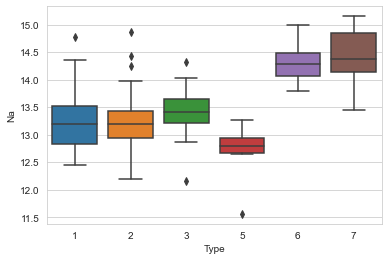

In [14]:
sns.boxplot(x = 'Type', y = 'Na', data = clean_df)

In [17]:
clean_df = clean_data(df,['Type'])


3
3
0
3
4
3
5
9
2


In [18]:
get_rf_score(clean_df, max_depth=10)

0.6216216216216216


Точность упала с 0.67 до 0.62.

In [19]:
clean_df_4 = clean_data(df,['Type'],n_sig=4)
get_rf_score(clean_df_4, max_depth=10)

2
1
0
1
0
2
3
2
1
0.6829268292682927


Вывод - простое удаление по 3 сигма удалило часть важной информации. Зато по сигма 4 - увеличило точность до 0.68.
Метод не надежный, хоть и действенный.   
Скорее всего решающим фактором нестабильности этого метода является малое количество исходных данных.
Несмотря на то, что удалили очень мало данных - единицы.
Нужен более тонкий подход. И совсем не факт, что автоматизированное удаление выбросов эфеективно для таких малых наборов задач.
Похоже, нужно править распределение. Вероятно, часть величин имеют два "горба" распределений.